The goal is to build a histogram of the number of visits expected for K/M dwarfs over the first couple of years of the survey.

## Set up

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from lsst.rsp import get_tap_service, retrieve_query

In [2]:
service = get_tap_service()

In [3]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

## Cumulative histogram of visit MJDs for any given sky location

This first query simply builds a histogram of the number of r-band visits on a patch of the sky near the center of DC2.

This cumulative histogram plotted below gives a general idea of (i.e., is representative of) the number of r-band visits expected for *any* kind of object, including K/M dwarfs.

This could be repeated for a bunch of different coordinates ('sightlines') to show variation in the histogram of the number of r-band visits that any given patch of sky gets.

In [4]:
%%time
query = "SELECT ra, decl, obsStartMJD, band " + \
        "FROM dp02_dc2_catalogs.Visit " + \
        "WHERE CONTAINS(POINT('ICRS', ra, decl), CIRCLE('ICRS', 62, -37, 2.0)) = 1 " + \
        "AND band = 'r'"
results = service.search(query)        

CPU times: user 15.8 ms, sys: 1.84 ms, total: 17.7 ms
Wall time: 99.6 ms


In [5]:
print(len(results))

144


In [6]:
# results.to_table()

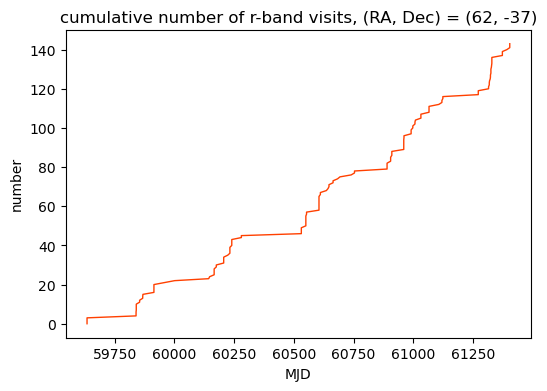

In [7]:
fig = plt.figure(figsize=(6, 4))
plt.plot(np.sort(results['obsStartMJD']), np.arange(len(results['obsStartMJD'])), \
         ls='solid', color=plot_filter_colors['r'], lw=1)
plt.xlabel('MJD')
plt.ylabel('number')
plt.title('cumulative number of r-band visits, (RA, Dec) = (62, -37)')
plt.show()

In [8]:
del query, results

## Components of the original query

The above query for a single sightline might satisfy the science goal, but it is pretty different from what the original query was doing.

Take another look at the original query:

```
query = "SELECT ROUND(dp02_dc2_catalogs.CcdVisit.obsStartMJD, -1) as mjd_index, COUNT(*) as n "\
        "FROM dp02_dc2_catalogs.ForcedSource as source "\
        "JOIN dp02_dc2_catalogs.Object as obj ON source.objectId = obj.objectId "\
        "JOIN dp02_dc2_catalogs.CcdVisit on source.ccdVisitId = dp02_dc2_catalogs.CcdVisit.ccdVisitId "\
        "WHERE scisql_nanojanskyToAbMag(obj.g_psfFlux) - scisql_nanojanskyToAbMag(obj.r_psfFlux) > 0.4 "\
        "AND scisql_nanojanskyToAbMag(obj.g_psfFlux) - scisql_nanojanskyToAbMag(obj.r_psfFlux) < 1.5 "\
        "AND scisql_nanojanskyToAbMag(obj.r_psfFlux) - scisql_nanojanskyToAbMag(obj.i_psfFlux) > 0 "\
        "AND scisql_nanojanskyToAbMag(obj.r_psfFlux) - scisql_nanojanskyToAbMag(obj.i_psfFlux) < 1.2 "\
        "AND obj.detect_isPrimary = 1 AND obj.g_extendedness = 0 AND obj.r_extendedness = 0 AND obj.i_extendedness = 0 "\
        "AND dp02_dc2_catalogs.CcdVisit.obsStartMJD < 60919 "\
        "GROUP BY mjd_index "
```

The above query is retrieving the `obsStartMJD` for the `CcdVisit` that corresponds to each and every one of the `ForcedSource` catalog entries that are associated with the `Object` catalog entries that have a g-r and r-i color that are like a K/M dwarf star. 

This is a very large query, and a complicated one due to the triple table join.

The following investigates to understand the scope of the query, and see about simplifying it.

The first query, below, checks how many `Objects` have colors like K/M dwarfs and are within a 1 degree area near the center (~3 square degrees, about a third of the LSST FOV).

In [11]:
%%time
query = "SELECT objectId, coord_ra, coord_dec " + \
        "FROM dp02_dc2_catalogs.Object AS obj " + \
        "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), CIRCLE('ICRS', 62, -37, 1.0)) = 1 " + \
        "AND scisql_nanojanskyToAbMag(obj.g_psfFlux) - scisql_nanojanskyToAbMag(obj.r_psfFlux) > 0.4 "\
        "AND scisql_nanojanskyToAbMag(obj.g_psfFlux) - scisql_nanojanskyToAbMag(obj.r_psfFlux) < 1.5 "\
        "AND scisql_nanojanskyToAbMag(obj.r_psfFlux) - scisql_nanojanskyToAbMag(obj.i_psfFlux) > 0 "\
        "AND scisql_nanojanskyToAbMag(obj.r_psfFlux) - scisql_nanojanskyToAbMag(obj.i_psfFlux) < 1.2 "\
        "AND obj.detect_isPrimary = 1 AND obj.g_extendedness = 0 AND obj.r_extendedness = 0 AND obj.i_extendedness = 0 "
results = service.search(query)      

CPU times: user 416 ms, sys: 9.87 ms, total: 426 ms
Wall time: 1.64 s


In [12]:
print(len(results))

45733


The above finds that there are ~45000 K/M dwarf-like `Objects` within 3 square degrees, which means there are ~135000 K/M dwarf-like `Objects` within an LSST FOV.

The full area of DC2 is 300 square degrees, so a full-area query would return ~4.5 million K/M dwarf-like `Objects`.

To take another step closer to the original query, the following cell retrieves the visit history for just 9 of the K/M dwarf-like `Objects` identified above, and plots the cumulative histogram in all six filters. 

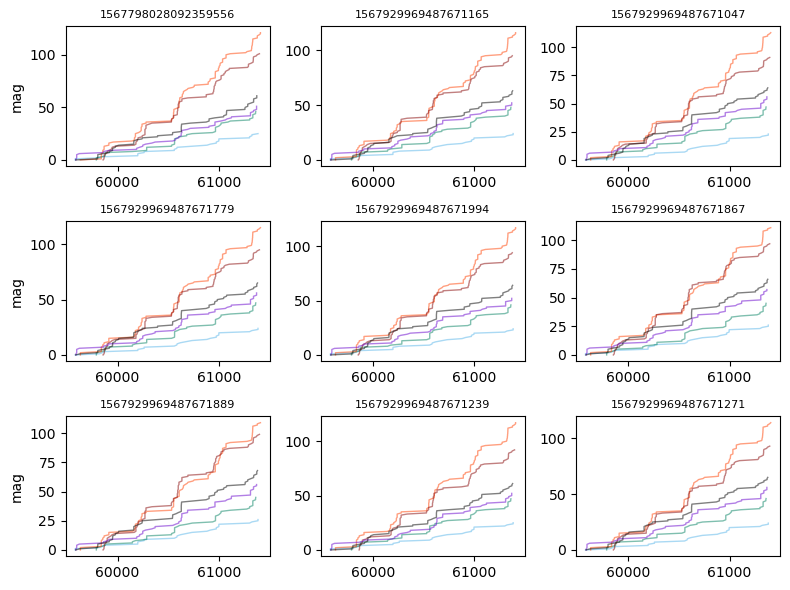

CPU times: user 815 ms, sys: 305 ms, total: 1.12 s
Wall time: 1.57 s


In [14]:
%%time
fig, ax = plt.subplots(3, 3, figsize=(8, 6), sharey=False, sharex=False)
x = 0

for i in range(3):
    for j in range(3):
        use_objectId = results['objectId'][x]
        temp = service.search("SELECT fsrc.objectId AS fsrc_objectId, "
                                 "fsrc.band AS fsrc_band, "
                                 "fsrc.ccdVisitId AS fsrc_ccdVisitId, "
                                 "cvis.expMidptMJD AS cvis_expMidptMJD "
                                 "FROM dp02_dc2_catalogs.ForcedSource AS fsrc "
                                 "JOIN dp02_dc2_catalogs.CcdVisit AS cvis ON fsrc.ccdVisitId = cvis.ccdVisitId "
                                 "WHERE fsrc.objectId = "+str(use_objectId))
        table = temp.to_table()

        for f, filt in enumerate(plot_filter_labels):
            fx = np.where(table['fsrc_band'] == filt)[0]
            ax[i, j].plot(np.sort(table['cvis_expMidptMJD'][fx]), np.arange(len(fx)),
                          ls='solid', lw=1, alpha=0.5, color=plot_filter_colors[filt])
            del fx
        ax[i, j].set_title(str(use_objectId), fontsize=8)
        if i == 4:
            ax[i, j].xaxis.set_label_text('MJD (days)')
        if j == 0:
            ax[i, j].yaxis.set_label_text('mag')
        x += 1
        del table

plt.tight_layout()
plt.show()

The six-filter visit history for any given `Object` has ~400 observations.

Retrieving all of the visit dates for all observations of every K/M dwarf-like `Object` would amount to a retrieved catalog with 1.8 billion dates. 

That's very large and would likely cause the kernel to crash if we tried it.

I'm not sure that's what is causing the 500 Server Error exactly, but it seems likely.

Option: plot the full `ForcedSource` lightcurves for 9 of these K/M dwarf type stars as a 3x3 grid.

In [ ]:
# %%time
# fig, ax = plt.subplots(3, 3, figsize=(8, 6), sharey=False, sharex=False)
# x = 0

# for i in range(3):
#     for j in range(3):
#         use_objectId = results['objectId'][x]
#         temp = service.search("SELECT fsrc.objectId AS fsrc_objectId, "
#                                  "fsrc.band AS fsrc_band, "
#                                  "fsrc.ccdVisitId AS fsrc_ccdVisitId, "
#                                  "scisql_nanojanskyToAbMag(fsrc.psfFlux) AS fsrc_psfMag, "
#                                  "cvis.expMidptMJD AS cvis_expMidptMJD "
#                                  "FROM dp02_dc2_catalogs.ForcedSource AS fsrc "
#                                  "JOIN dp02_dc2_catalogs.CcdVisit AS cvis ON fsrc.ccdVisitId = cvis.ccdVisitId "
#                                  "WHERE fsrc.objectId = "+str(use_objectId))
#         table = temp.to_table()

#         for f, filt in enumerate(plot_filter_labels):
#             fx = np.where(table['fsrc_band'] == filt)[0]
#             ax[i, j].plot(table['cvis_expMidptMJD'][fx], table['fsrc_psfMag'][fx],
#                           plot_filter_symbols[filt], ms=5, mew=0, alpha=0.5,
#                           color=plot_filter_colors[filt])
#             del fx

#         ax[i, j].invert_yaxis()
#         ax[i, j].set_title(str(use_objectId), fontsize=8)
#         if i == 4:
#             ax[i, j].xaxis.set_label_text('MJD (days)', fontsize=8)
#         if j == 0:
#             ax[i, j].yaxis.set_label_text('mag', fontsize=8)
#         x += 1
#         del table

# plt.tight_layout()
# plt.show()